In [8]:
from subprocess import check_output
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Sequential

## Первинний аналіз даних
www.kaggle.com/sumanthvrao/daily-climate-time-series-data

In [23]:
data = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv', parse_dates=["date"])
# test = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTest.csv', parse_dates=["date"])

data = data.set_index("date").sort_index()

In [24]:
data.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


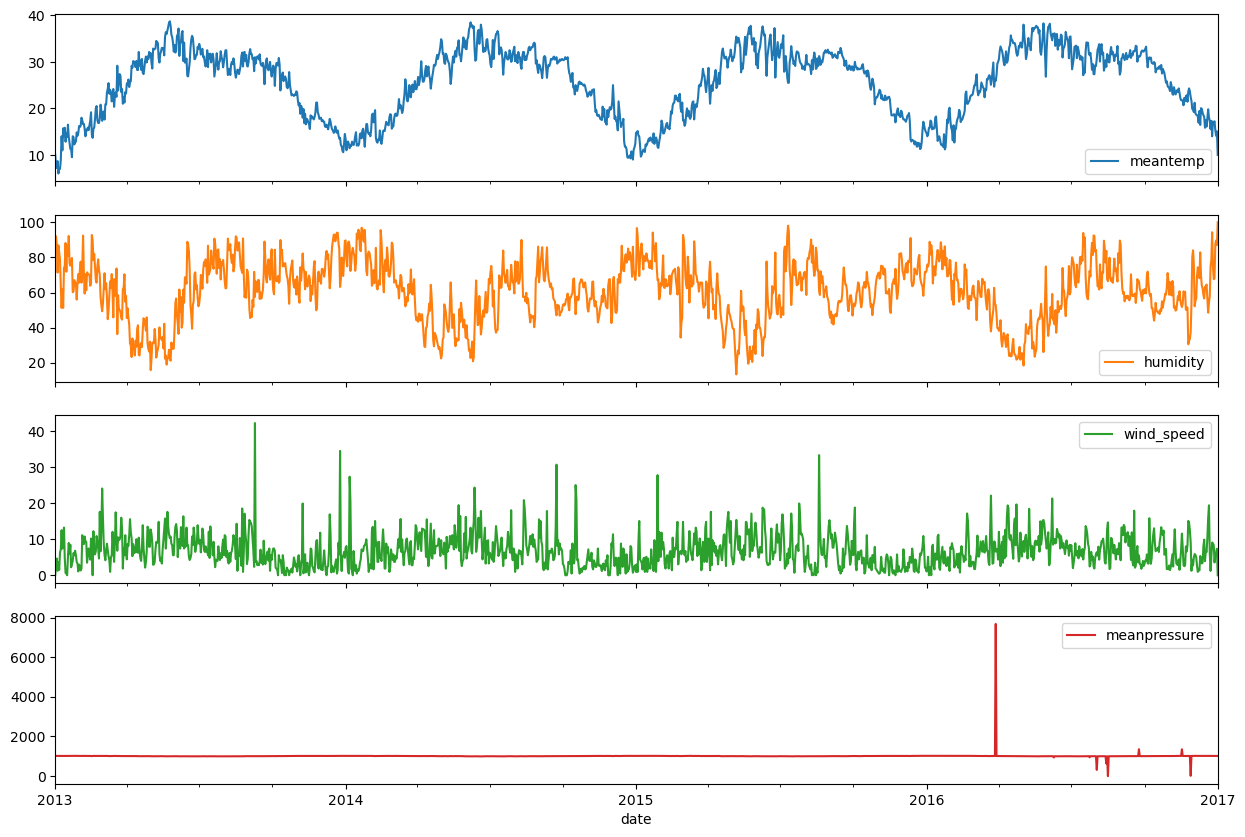

In [25]:
data.plot(subplots=True, figsize=(15, 10));

In [26]:
print(data.isna().sum())

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [27]:
np.all(data.resample('D').asfreq().index == data.index)

True

## Підготовка даних

<AxesSubplot:xlabel='date'>

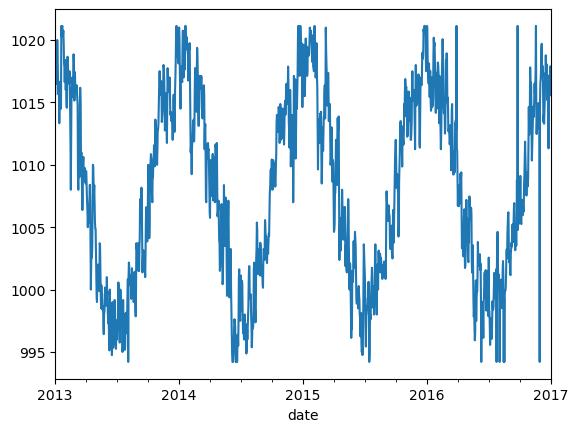

In [28]:
low = data["meanpressure"].quantile(.01)
high = data["meanpressure"].quantile(.99)

data["meanpressure"] = data["meanpressure"].clip(low, high)
data["meanpressure"].plot()

In [29]:
size = len(data)
train, test = data.iloc[:3 * size // 4], data.iloc[3 * size // 4:]

scaler = StandardScaler()

train = scaler.fit_transform(train)
test = scaler.transform(test)

## Експерименти

In [30]:
def create_dataset(X, window_size=14, target_size=1):
    # Create a sliding window view of the dataset
    t, n = X.shape
    X_slide = np.zeros((t - window_size - target_size + 1, window_size + target_size, n))

    for i in range(X_slide.shape[0]):
        X_slide[i] = X[i: i + window_size + target_size]
    return X_slide[:, : window_size], X_slide[:, window_size:]

In [115]:
def longterm_forecast(model, num_steps, X_init, num_predict=1, slice_input=None):
    init, n = X_init.shape

    X_pred = np.zeros((num_steps + init, n))
    X_pred[:init] = X_init

    for i in range(0, num_steps, num_predict):
        d = min(num_predict, len(X_pred) - init + i + num_predict)
        inp = X_pred[None, : init + i]
        if slice_input:
            inp = inp[:, -slice_input:]
        X_pred[init + i: init + i + num_predict] = model.predict(inp, verbose=0)[0][:d]

    return X_pred[init:]


def plot_prediction(y_true, y_pred, labels=None):
    fig, axs = plt.subplots(nrows=y_true.shape[1], ncols=1, figsize=(10,7))
    if not labels:
        labels = range(y_true.shape[1])

    # plot each column in a separate subplot
    for ax, true, pred, col in zip(axs, y_true.T, y_pred.T, labels):
        ax.plot(true, label='True')
        ax.plot(pred, label='Prediction')
        ax.set_title(f'Column {col}')
        ax.legend()
        ax.grid()
    fig.tight_layout()


def run_experiment(
    train,
    test,
    window_size,
    target_size,
    get_model,
    get_model_kwargs={},
    train_kwargs={},
    longterm_forecast_kwargs={},
    labels=[],
):

    train_kwargs = {**dict(epochs=100, batch_size=32), **train_kwargs}
    X_train, Y_train = create_dataset(train, window_size, target_size)
    model = get_model(*X_train.shape[2:], target_size, **get_model_kwargs)
    
    model.compile(optimizer='adam', loss='mse', metrics=["mse"])
    # Train the model
    history = model.fit(X_train, Y_train, **train_kwargs, validation_split=0.2)
    forecast = longterm_forecast(model, len(test), train, **longterm_forecast_kwargs)

    mae = np.mean(np.abs(forecast - test))
    mse = np.mean((forecast - test)**2)
    mape = np.mean(np.abs((forecast - test) / test))
    
    metrics = pd.Series({"mae": mae, "mse": mse, "mape": mape})
    
    clear_output()
    print(metrics)
    df = pd.DataFrame(history.history).filter(like="loss")
    df.plot(subplots=False, grid=True, figsize=(10, 3), title="Loss/epoch")
    plot_prediction(test, forecast, labels)
    return model, metrics


### Одношарові моделі
Побудуємо модель, використовуючи один шар базових рекурентних нейронiв, та аналогiчнi моделi iз одним шаром комiрок LSTM i GRU.

Підберемо кiлькiсть нейронiв у рекурентному шарi, кiлькiсть
часових крокiв, а також кiлькiсть епох i розмiр батчу, щоб покращити
якiсть прогнозiв.

In [49]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Reshape



def get_one_layer_model(n, target_size, n_units=64, RNNLayer=SimpleRNN):
    model = Sequential()
    model.add(RNNLayer(n_units, input_shape=(None, n)))
    model.add(Dense(target_size * n))
    model.add(Reshape((target_size, n)))
    return model

mae     0.851451
mse     1.202012
mape    3.816217
dtype: float64


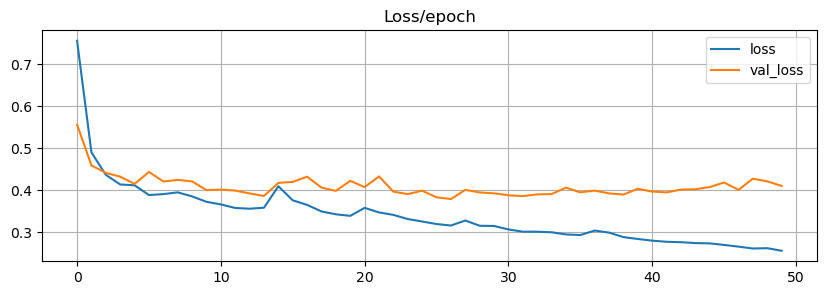

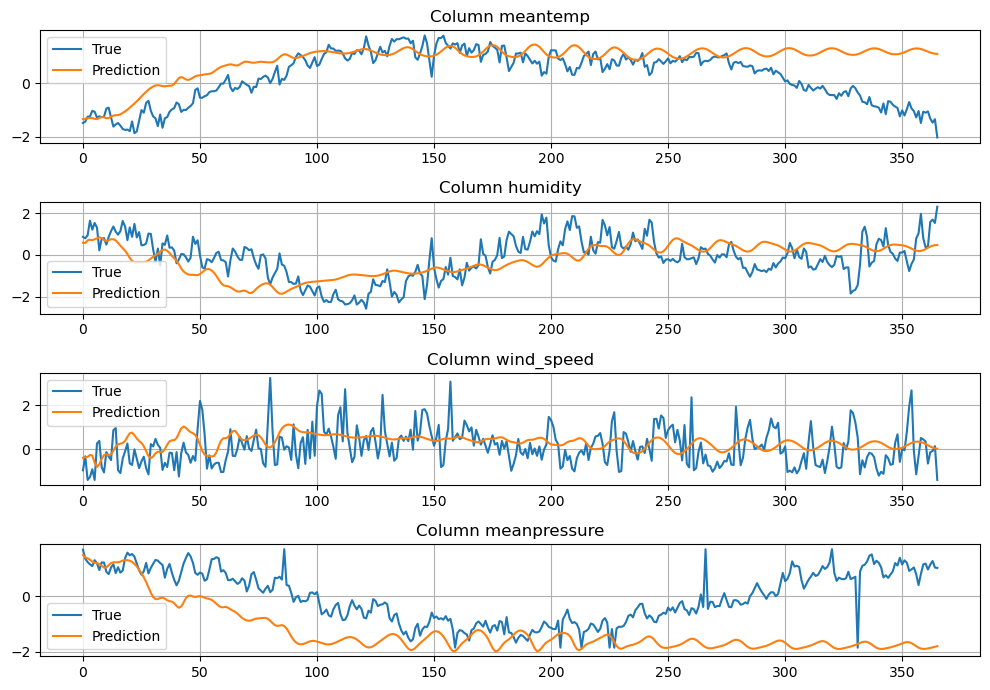

In [64]:
model, metrics = run_experiment(
    train, test,
    window_size=56,
    target_size=28,
    get_model=get_one_layer_model,
    get_model_kwargs={
        "RNNLayer": SimpleRNN,
        "n_units": 128,
    },
    train_kwargs={
        "epochs": 50
    },
    labels=list(data.columns)
)

mae     0.652453
mse     0.770730
mape    2.601589
dtype: float64


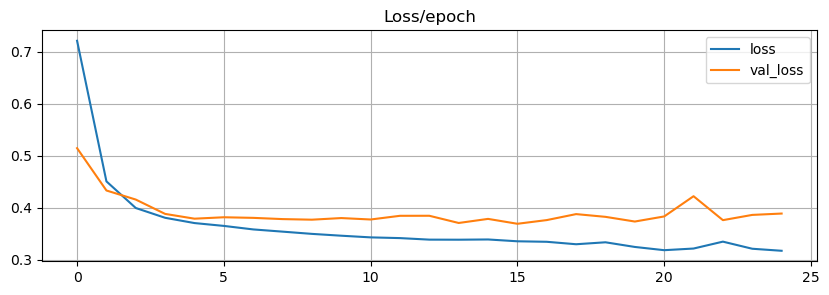

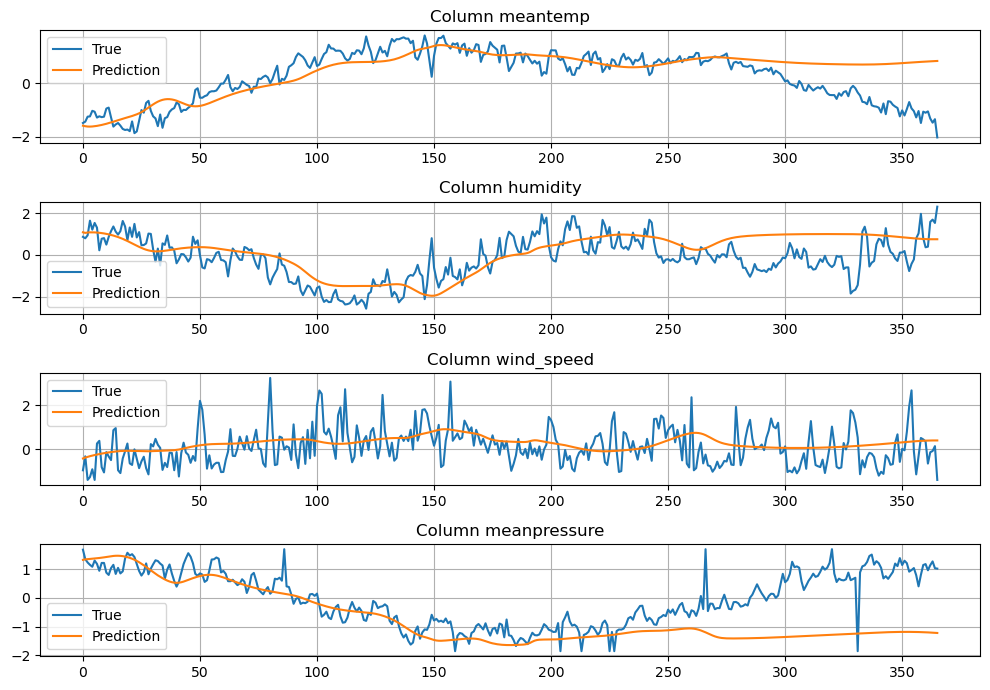

In [72]:
model, metrics = run_experiment(
    train, test,
    window_size=56,
    target_size=28,
    get_model=get_one_layer_model,
    get_model_kwargs={
        "RNNLayer": LSTM,
        "n_units": 128,
    },
    train_kwargs={
        "epochs": 25
    },
    labels=list(data.columns)
)

mae     0.649787
mse     0.782653
mape    2.590434
dtype: float64


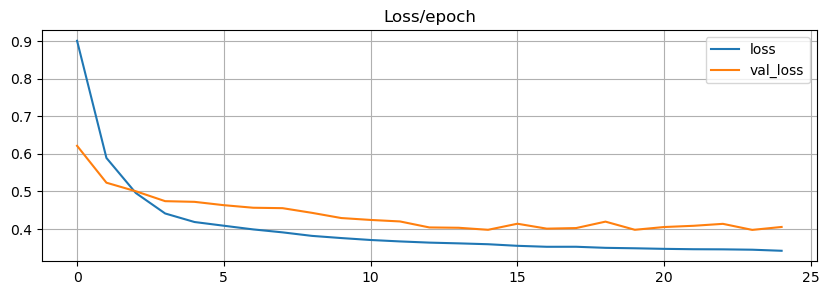

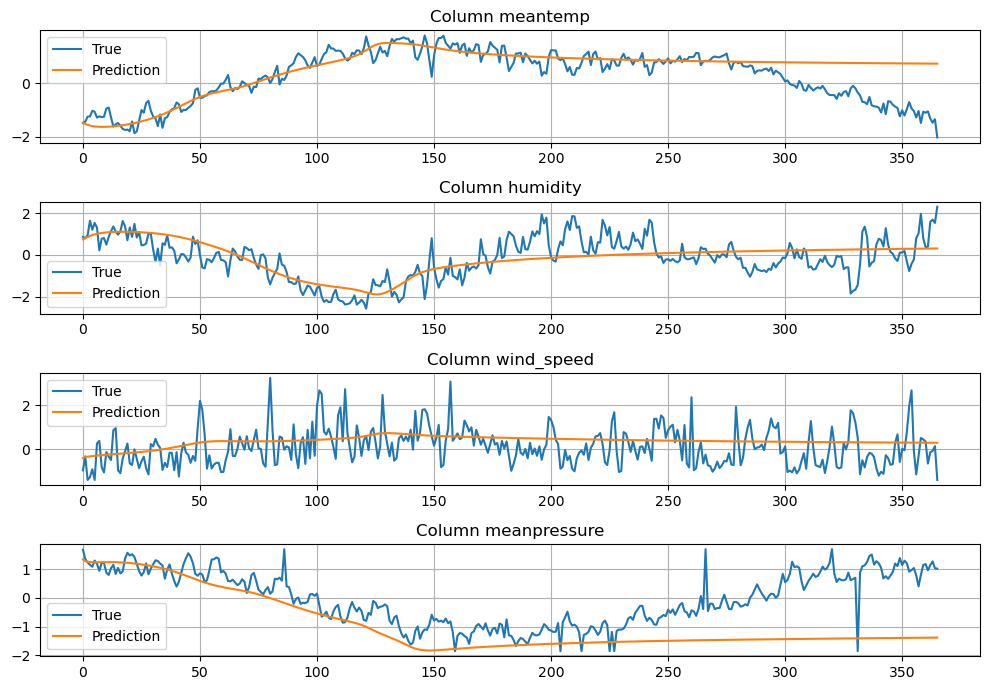

In [73]:
model, metrics = run_experiment(
    train, test,
    window_size=56,
    target_size=28,
    get_model=get_one_layer_model,
    get_model_kwargs={
        "RNNLayer": GRU
    },
    train_kwargs={
        "epochs": 25
    },    
    labels=list(data.columns)
)

### Глибокі моделі

In [80]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Reshape, Dropout


def get_deep_model(n, target_size, n_units=64, dropout_p=None, RNNLayer=SimpleRNN):
    model = Sequential()
    model.add(RNNLayer(n_units, return_sequences=True, input_shape=(None, n)))
    if dropout_p is not None:
        model.add(Dropout(dropout_p))
    model.add(RNNLayer(n_units, return_sequences=True))
    if dropout_p is not None:
        model.add(Dropout(dropout_p))
    model.add(RNNLayer(n_units))
    model.add(Dense(target_size * n))
    model.add(Reshape((target_size, n)))
    return model

mae     0.598226
mse     0.587569
mape    2.269963
dtype: float64


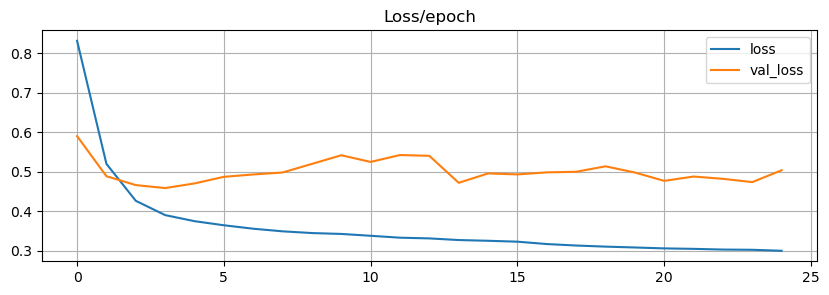

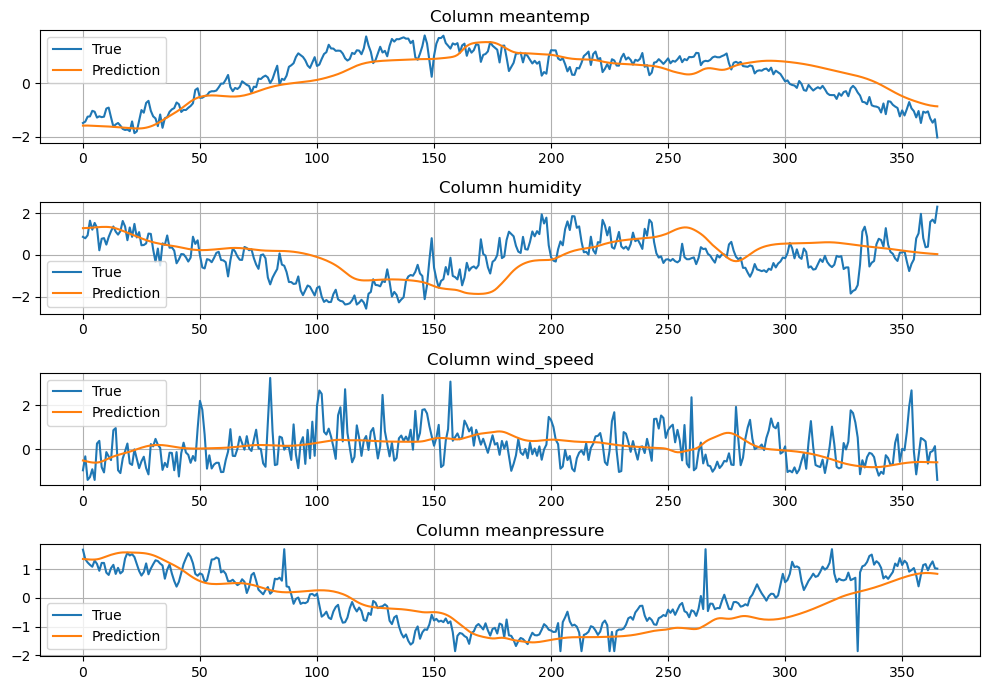

In [81]:
model, metrics = run_experiment(
    train, test,
    window_size=56,
    target_size=28,
    get_model=get_deep_model,
    get_model_kwargs={
        "RNNLayer": LSTM,
        "n_units": 64,
    },
    train_kwargs={
        "epochs": 25
    },
    labels=list(data.columns)
)

mae     0.787242
mse     1.027077
mape    3.456573
dtype: float64


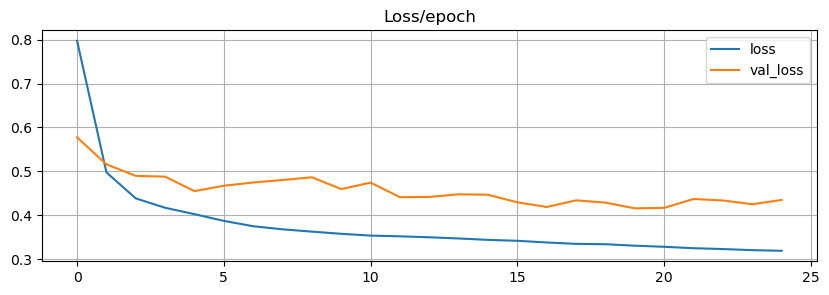

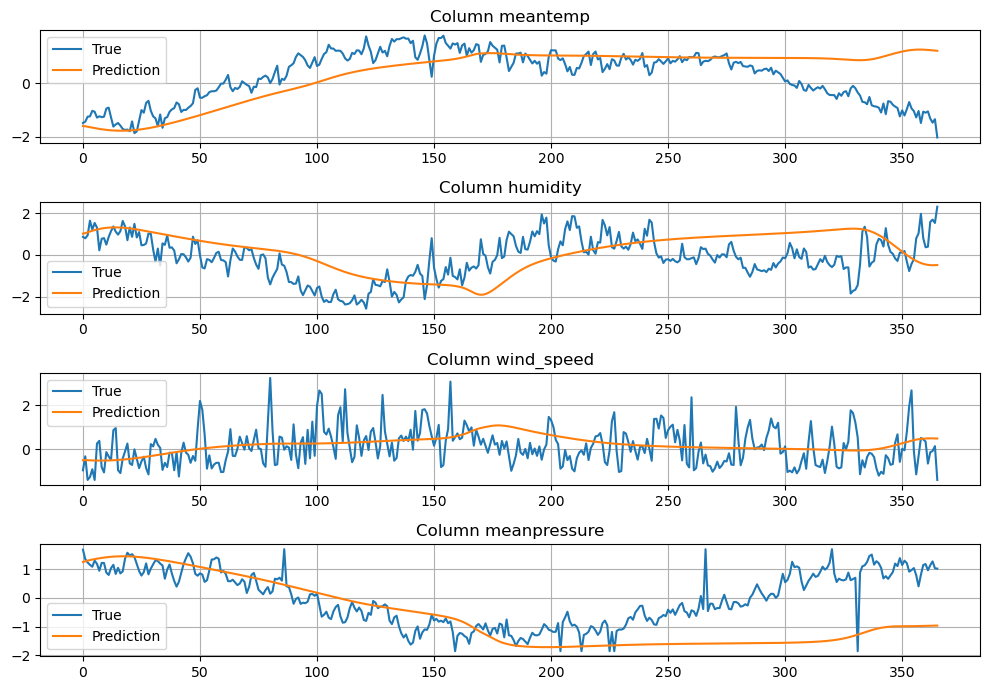

In [82]:
model, metrics = run_experiment(
    train, test,
    window_size=56,
    target_size=28,
    get_model=get_deep_model,
    get_model_kwargs={
        "RNNLayer": GRU,
        "n_units": 64,
    },
    train_kwargs={
        "epochs": 25
    },
    labels=list(data.columns)
)

### Дропаути

mae     0.461930
mse     0.391746
mape    1.719706
dtype: float64


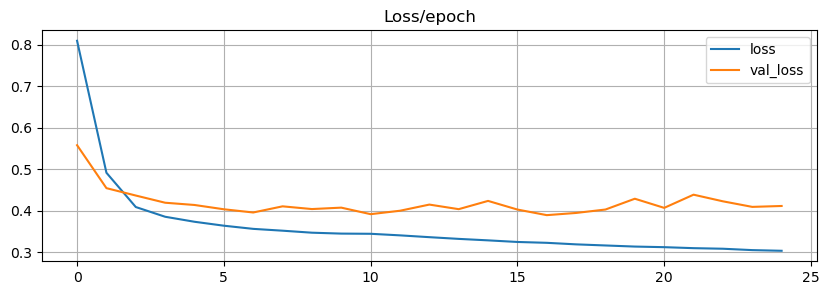

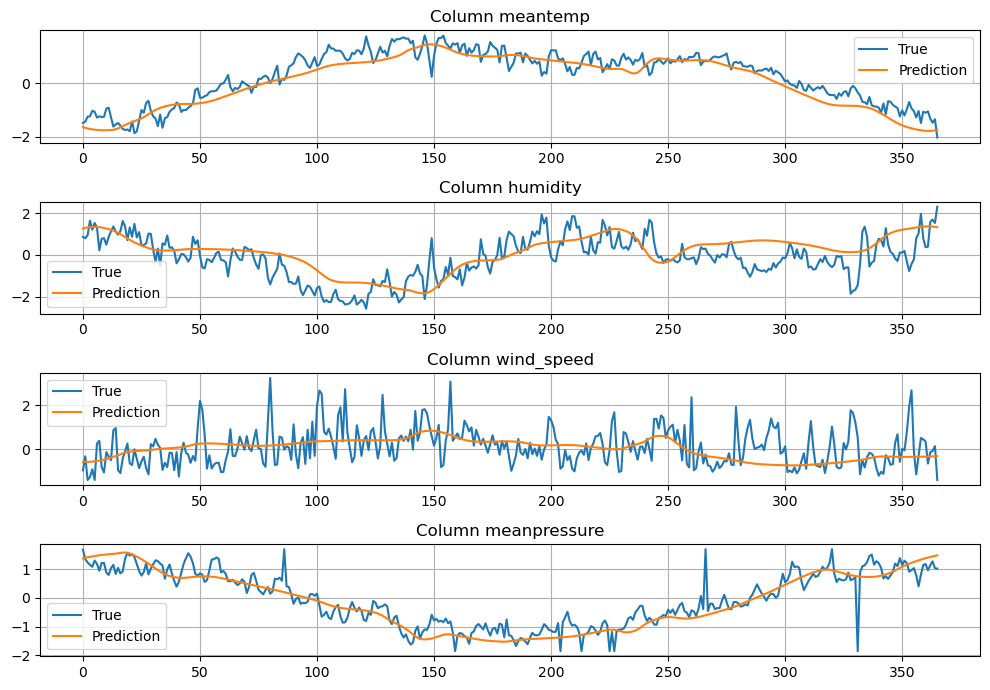

In [83]:
model, metrics = run_experiment(
    train, test,
    window_size=56,
    target_size=28,
    get_model=get_deep_model,
    get_model_kwargs={
        "RNNLayer": LSTM,
        "n_units": 64,
        "dropout_p": 0.1
    },
    train_kwargs={
        "epochs": 25
    },
    labels=list(data.columns)
)

mae     0.704470
mse     0.781495
mape    2.837150
dtype: float64


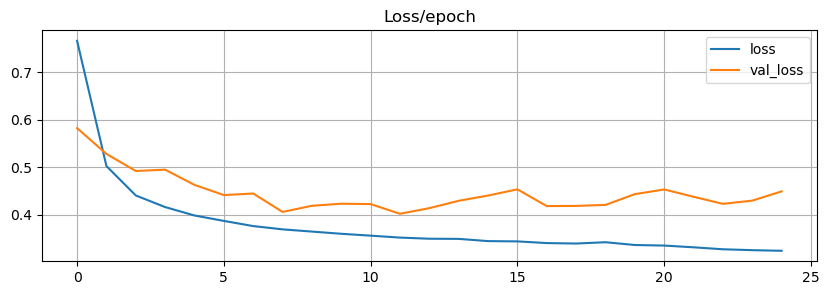

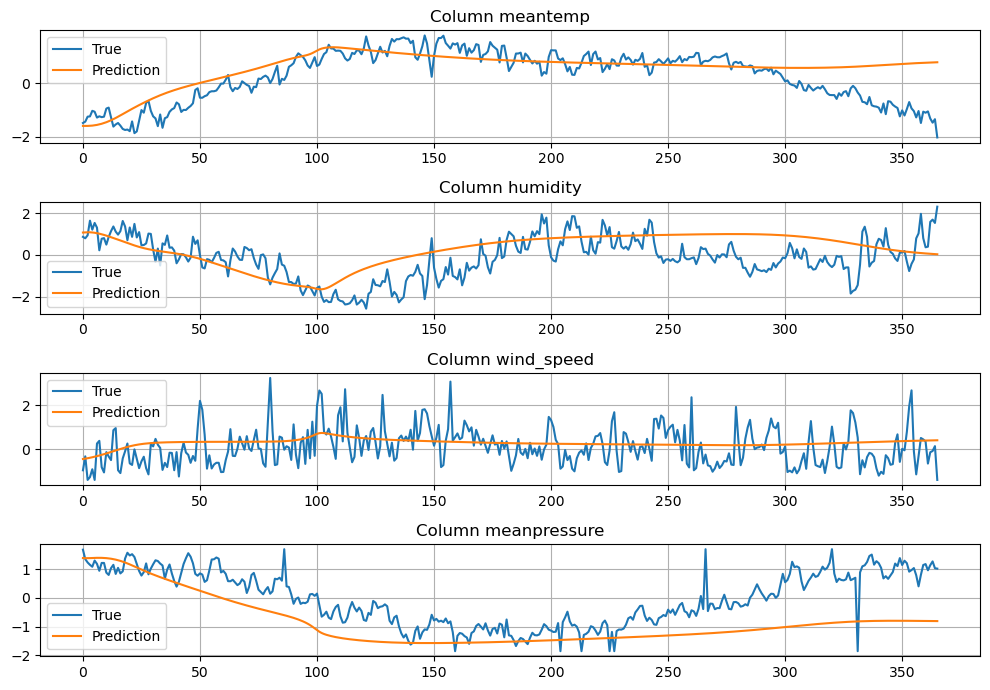

In [84]:
model, metrics = run_experiment(
    train, test,
    window_size=56,
    target_size=28,
    get_model=get_deep_model,
    get_model_kwargs={
        "RNNLayer": GRU,
        "n_units": 64,
        "dropout_p": 0.1
    },
    train_kwargs={
        "epochs": 25
    },
    labels=list(data.columns)
)

### Conv1D

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


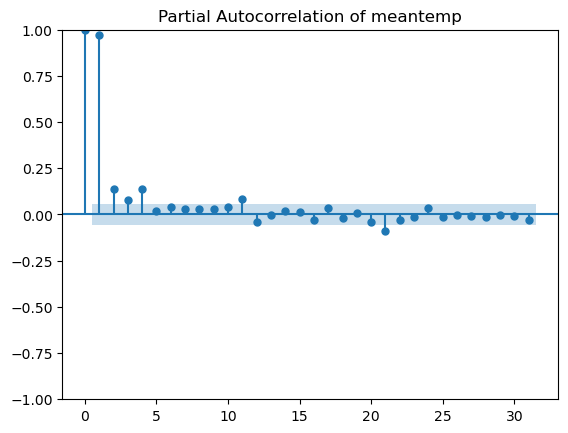

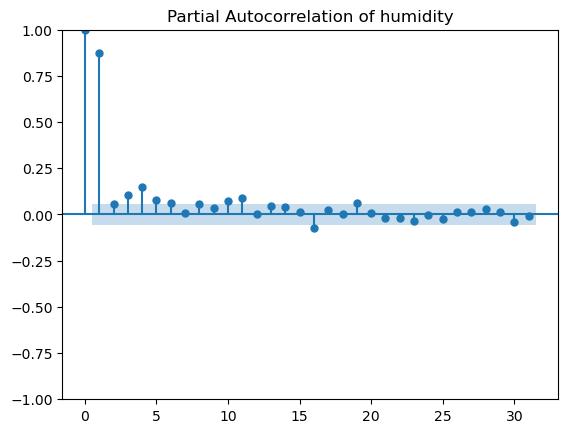

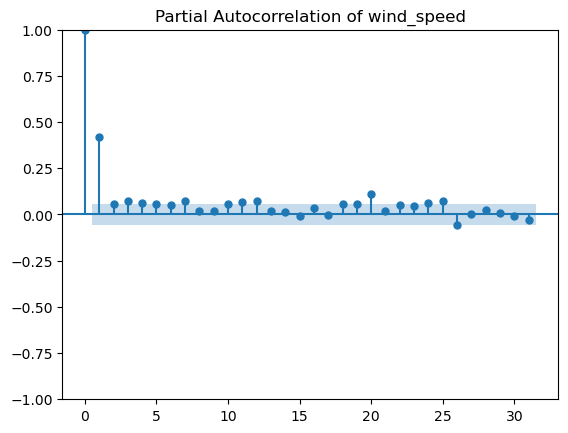

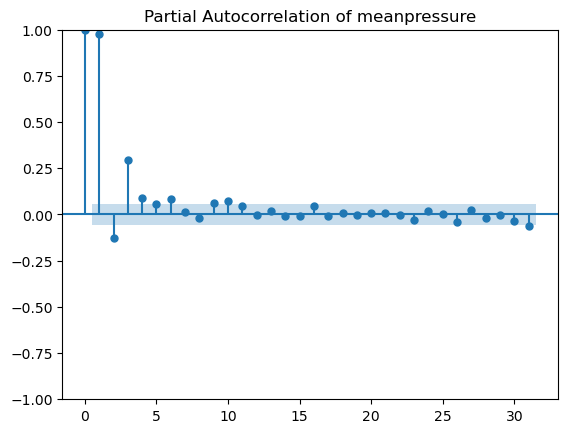

In [118]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for i, col in enumerate(data.columns):
    plot_pacf(train[:, i], ax=plt.gca());
    plt.title(f"Partial Autocorrelation of {col}")
    plt.show()

Зафарбована зона позначає область прийняття гіпотези про відсутність автокореляції. Можемо зробити висновок про присутність цього явища в усіх змінних.

In [104]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Conv1D, MaxPool1D, Flatten, Input


def get_conv_model(n, target_size, window_size, n_units=64, dropout_p=None, RNNLayer=SimpleRNN):
    
    inp = Input((window_size, n))
    x = Conv1D(n_units, 5, 1, padding='same', activation='relu')(inp)
    x = Conv1D(n_units, 5, 1, padding='same', activation='relu')(x)
    x = MaxPool1D(2)(x)
    x = Conv1D(n_units, 5, 1, padding='same', activation='relu')(x)
    x = Conv1D(n_units, 5, 1, padding='same', activation='relu')(x)
    x = MaxPool1D(2)(x)
    x = Flatten()(x)
    x = Dense(target_size * n)(x)
    x = Reshape((target_size, n))(x)
    model = Model(inputs=inp, outputs=x)
    return model

mae     0.633982
mse     0.617956
mape    1.315445
dtype: float64


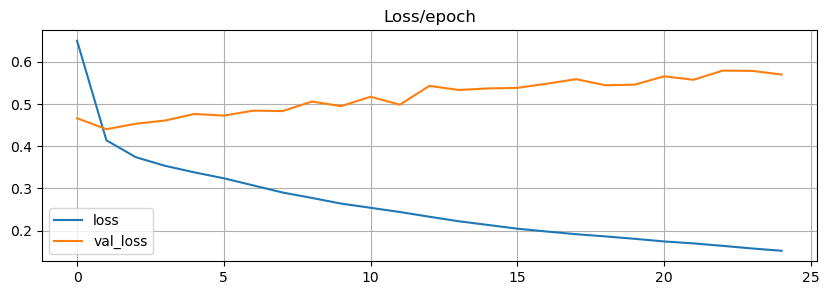

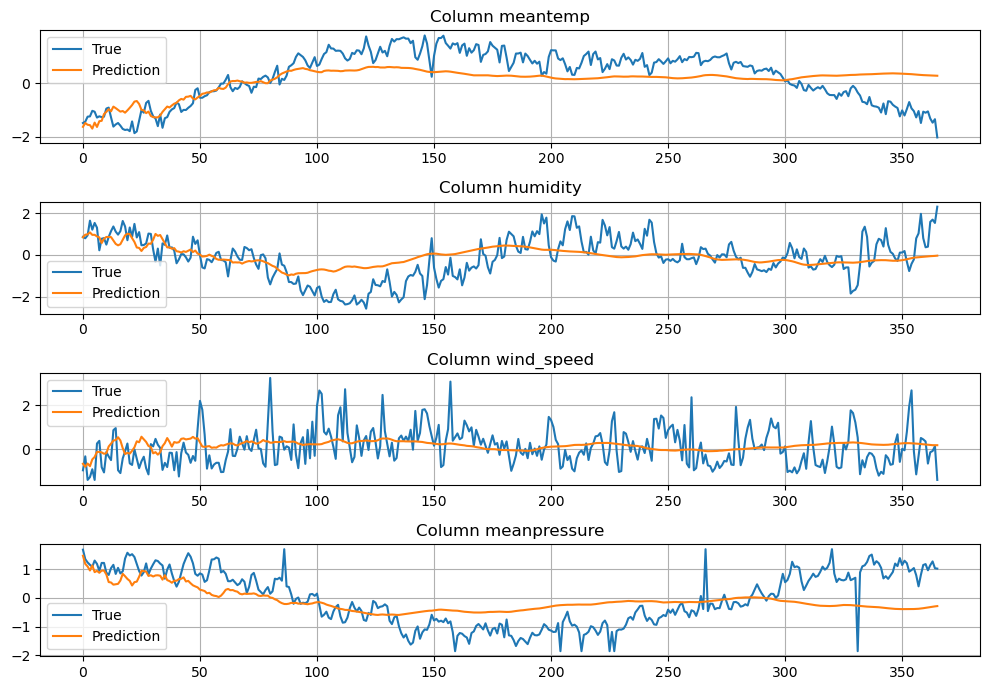

In [117]:
window_size = 56

model, metrics = run_experiment(
    train, test,
    window_size=window_size,
    target_size=28,
    get_model=get_conv_model,
    get_model_kwargs={
        "n_units": 64,
        "window_size": window_size
    },
    train_kwargs={
        "epochs": 25
    },
    longterm_forecast_kwargs={
        "slice_input": window_size,
    },
    labels=list(data.columns)
)

## Висновки:

Відповідно до показників MAE, MAPE, MSE, найкраще себе показала глибока модель з LSTM шарами та дропаутами між ними - ця комбінація допомагає моделі гарно вивчити зв'язки в даних, і при цьому запобігає перенавчанню. Також непогано спрацювала аналогічна модель без дропаутів, та модель зі згортковими шарами, при цьому згорткова модель більш схильна до спроби вгадати піки, в той час як LSTM добре прогнозує загальний тренд - можливо, оптимальна модель повинна містити обидва типа шарів. Шари GRU для цієї задачі не спрацювали достатньо добре, прогноз моделі получився схожим на екстраполяцію середнього за ковзним вікном, що є непоганою відправною точкою, проте не підходить для високоточного прогнозуванння і подальшого прийняття рішень.